# A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" published in **IEEE International Conference on Communications (IEEE ICC)**, doi=[10.1109/ICC45855.2022.9838780](https://ieeexplore.ieee.org/document/9838780).    
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 3: Ensemble Models**  
Aims:  construct three ensemble techniques: Bagging, Probability averaging, and Concatenation, to further improve prediction accuracy  
* Bagging: use majority voting of top single models  
* Probability averaging: calculate the average probability of the single model prediction results (the last layer of CNN models), and select the largest probability class to be the final class  
* Concatenation: extract the features in the last several layers of single models, and concatenate together to generate the new layers, and add a dense layer to do prediction

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

Using TensorFlow backend.


## Read the test set

In [2]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 5845 images belonging to 5 classes.


In [3]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [4]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [5]:
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\100015.png


## Load 5 trained CNN models

In [7]:
 #load model 1: xception
xception_model=load_model('./xception.h5')

In [9]:
 #load model 2: VGG16
vgg_model=load_model('./VGG16.h5')

In [10]:
 #load model 3: VGG19
vgg19_model=load_model('./VGG19.h5')

In [11]:
 #load model 4: inception
incep_model=load_model('./inception.h5')

In [12]:
 #load model 5: inceptionresnet
inres_model=load_model('./inceptionresnet.h5')

## Use the original CNN base models to make predictions

### 1. Xception

Predicted result for the first image: 0
Confidence level: 1.0


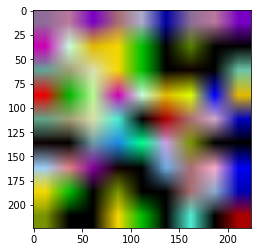

In [20]:
#Single image prediction
import cv2
import matplotlib.pyplot as plt
test=cv2.imread(test_images[0])

img_show=test[:,:,[2,1,0]]
test=test/255.
test_shape=(1,)+test.shape
test=test.reshape(test_shape)

res=xception_model.predict(test)

prob=res[0,np.argmax(res,axis=1)[0]]
res=label[np.argmax(res,axis=1)[0]]
print('Predicted result for the first image: %s'%res)
print('Confidence level: %s'%prob)
plt.imshow(img_show)
plt.show()

In [12]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    xception_model_batch=xception_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=xception_model_batch[0,np.argmax(xception_model_batch,axis=1)[0]]
    res=label[np.argmax(xception_model_batch,axis=1)[0]]
    predict.append(res)
    

Wall time: 1min 26s


In [13]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('Xception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

Xception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



### 2. VGG16

In [14]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg_model_batch,axis=1)[0]]
    predict.append(res)
    

Wall time: 50 s


In [15]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('VGG16 accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

VGG16 accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



### 3. VGG19

In [16]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg19_model_batch=vgg19_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg19_model_batch[0,np.argmax(vgg19_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg19_model_batch,axis=1)[0]]
    predict.append(res)
    

Wall time: 56.6 s


In [17]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('VGG19 accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

VGG19 accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



### 4. Inception

In [18]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    incep_model_batch=incep_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=incep_model_batch[0,np.argmax(incep_model_batch,axis=1)[0]]
    res=label[np.argmax(incep_model_batch,axis=1)[0]]
    predict.append(res)
    

Wall time: 2min 19s


In [19]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

inception accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



### 5. InceptionResnet

In [20]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    inres_model_batch=inres_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=inres_model_batch[0,np.argmax(inres_model_batch,axis=1)[0]]
    res=label[np.argmax(inres_model_batch,axis=1)[0]]
    predict.append(res)
    

Wall time: 4min 25s


In [21]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('inceptionresnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

inceptionresnet accuracy: 0.9998289136013687
precision: 0.999829777674089
recall: 0.9998289136013687
f1: 0.9998288793066084
[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    1  170]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       0.99      1.00      1.00       197
           4       1.00      0.99      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



### 6. Resnet

In [22]:
 #load model 6: resnet
res_model=load_model('./resnet.h5')

In [23]:
%%time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    res_model_batch=res_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=res_model_batch[0,np.argmax(res_model_batch,axis=1)[0]]
    res=label[np.argmax(res_model_batch,axis=1)[0]]
    predict.append(res)
    

Wall time: 1min 38s


In [24]:
%%time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('resnet accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

resnet accuracy: 0.9662959794696322
precision: 0.9338569031275825
recall: 0.9662959794696322
f1: 0.9497662530625438
[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [ 197    0    0    0    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       0.00      0.00      0.00       197
           4       1.00      1.00      1.00       171

    accuracy                           0.97      5845
   macro avg       0.79      0.80      0.80      5845
weighted avg       0.93      0.97      0.95      5845

Wall time: 35.9 ms


Best performing single model (vgg):  
Accuracy: 99.96

# Bagging ensemble

In [25]:
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #generate result by model 1
    xception_model_batch=xception_model.predict(np.array(test_batch))
    xception_model_batch=list(np.argmax(xception_model_batch,axis=1))
    xception_model_batch=[label[con] for con in xception_model_batch]
#     print(xception_model_batch)
    #generate result by model 2
    vgg_model_batch=vgg_model.predict(np.array(test_batch))
    vgg_model_batch=list(np.argmax(vgg_model_batch,axis=1))
    vgg_model_batch=[label[con] for con in vgg_model_batch]
#     print(vgg_model_batch)
    #generate result by model 3
    vgg19_model_batch=vgg19_model.predict(np.array(test_batch))
    vgg19_model_batch=list(np.argmax(vgg19_model_batch,axis=1))
    vgg19_model_batch=[label[con] for con in vgg19_model_batch]
#     print(vgg19_model_batch)
    #generate result by model 4
    incep_model_batch=incep_model.predict(np.array(test_batch))
    incep_model_batch=list(np.argmax(incep_model_batch,axis=1))
    incep_model_batch=[label[con] for con in incep_model_batch]
#     print(incep_model_batch)
    #generate result by model 5
    inres_model_batch=inres_model.predict(np.array(test_batch))
    inres_model_batch=list(np.argmax(inres_model_batch,axis=1))
    inres_model_batch=[label[con] for con in inres_model_batch]
#     print(inres_model_batch)
    #bagging the three results generated by 3 singular models
    predict_batch=[]
    for i,j,k,p,q in zip(xception_model_batch,vgg_model_batch,vgg19_model_batch,incep_model_batch,inres_model_batch):
        count=defaultdict(int)
        count[i]+=1
        count[j]+=1
        count[k]+=1
        count[p]+=1
        count[q]+=1
        #rank the predicted results in descending order
        predict_one=sorted(count.items(), key=operator.itemgetter(1),reverse=True)[0][0]
        predict_batch.append(predict_one)
#     print('predict:',predict_batch)
    predict.append(predict_batch)
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :99.662228 seconds


In [26]:
predict=sum(predict,[])

In [27]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('bagging accuracy:%s'%acc)

bagging accuracy:1.0


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



After bagging ensemble, the accuracy improved to 0.990

# Probability Averaging

In [29]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout,Average
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [30]:
import time
t1 = time.time()
img=Input(shape=(224,224,3),name='img')
feature1=xception_model(img)
feature2=vgg_model(img)
feature3=incep_model(img)
for layer in xception_model.layers:  
    layer.trainable = False 
for layer in vgg_model.layers:  
    layer.trainable = False  
for layer in incep_model.layers:  
    layer.trainable = False  
output=Average()([feature1,feature2,feature3]) #add the confidence lists generated by 3 models
model=Model(inputs=img,outputs=output)

#the optimization function
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :2.661651 seconds


In [31]:
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\100015.png


In [32]:
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    model_batch=model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :51.721883 seconds


In [33]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(test_laels,predict)
print('Probability Averaging accuracy:%s'%acc)

Probability Averaging accuracy:1.0


In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845



# Concatenation

In [35]:
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD

In [36]:
for i,layer in enumerate(xception_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_15
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_16
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_17
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sep

In [37]:
for i,layer in enumerate(vgg_model.layers):
    print(i,layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_4
20 dense_7
21 dropout_4
22 dense_8


In [38]:
for i,layer in enumerate(vgg19_model.layers):
    print(i,layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_5
23 dense_9
24 dropout_5
25 dense_10


In [39]:
for i,layer in enumerate(incep_model.layers):
    print(i,layer.name)

0 input_5
1 conv2d_19
2 batch_normalization_5
3 activation_50
4 conv2d_20
5 batch_normalization_6
6 activation_51
7 conv2d_21
8 batch_normalization_7
9 activation_52
10 max_pooling2d_6
11 conv2d_22
12 batch_normalization_8
13 activation_53
14 conv2d_23
15 batch_normalization_9
16 activation_54
17 max_pooling2d_7
18 conv2d_27
19 batch_normalization_13
20 activation_58
21 conv2d_25
22 conv2d_28
23 batch_normalization_11
24 batch_normalization_14
25 activation_56
26 activation_59
27 average_pooling2d_1
28 conv2d_24
29 conv2d_26
30 conv2d_29
31 conv2d_30
32 batch_normalization_10
33 batch_normalization_12
34 batch_normalization_15
35 batch_normalization_16
36 activation_55
37 activation_57
38 activation_60
39 activation_61
40 mixed0
41 conv2d_34
42 batch_normalization_20
43 activation_65
44 conv2d_32
45 conv2d_35
46 batch_normalization_18
47 batch_normalization_21
48 activation_63
49 activation_66
50 average_pooling2d_2
51 conv2d_31
52 conv2d_33
53 conv2d_36
54 conv2d_37
55 batch_normaliza

In [40]:
for i,layer in enumerate(inres_model.layers):
    print(i,layer.name)

0 input_6
1 conv2d_113
2 batch_normalization_99
3 activation_144
4 conv2d_114
5 batch_normalization_100
6 activation_145
7 conv2d_115
8 batch_normalization_101
9 activation_146
10 max_pooling2d_10
11 conv2d_116
12 batch_normalization_102
13 activation_147
14 conv2d_117
15 batch_normalization_103
16 activation_148
17 max_pooling2d_11
18 conv2d_121
19 batch_normalization_107
20 activation_152
21 conv2d_119
22 conv2d_122
23 batch_normalization_105
24 batch_normalization_108
25 activation_150
26 activation_153
27 average_pooling2d_10
28 conv2d_118
29 conv2d_120
30 conv2d_123
31 conv2d_124
32 batch_normalization_104
33 batch_normalization_106
34 batch_normalization_109
35 batch_normalization_110
36 activation_149
37 activation_151
38 activation_154
39 activation_155
40 mixed_5b
41 conv2d_128
42 batch_normalization_114
43 activation_159
44 conv2d_126
45 conv2d_129
46 batch_normalization_112
47 batch_normalization_115
48 activation_157
49 activation_160
50 conv2d_125
51 conv2d_127
52 conv2d_1

### Construct the ensemble model using the last "dense layer" of each base CNN model

In [43]:

model1=Model(inputs=[xception_model.layers[0].get_input_at(0)],outputs=xception_model.get_layer('dense_6').output,name='xception')
model2=Model(inputs=[vgg_model.layers[0].get_input_at(0)],outputs=vgg_model.get_layer('dense_8').output,name='vgg')
model3=Model(inputs=[vgg19_model.layers[0].get_input_at(0)],outputs=vgg19_model.get_layer('dense_10').output,name='vgg19')
model4=Model(inputs=[incep_model.layers[0].get_input_at(0)],outputs=incep_model.get_layer('dense_14').output,name='incep')
model5=Model(inputs=[inres_model.layers[0].get_input_at(0)],outputs=inres_model.get_layer('dense_16').output,name='inres')

In [44]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [45]:
ensemble_history= LossHistory()

In [46]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 23382 images belonging to 5 classes.
Found 5845 images belonging to 5 classes.


In [47]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [48]:
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [49]:
def ensemble(num_class,epochs,savepath='./ensemble.h5'):
    img=Input(shape=(224,224,3),name='img')
    feature1=model1(img)
    feature2=model2(img)
    feature3=model3(img)
    x=concatenate([feature1,feature2,feature3])
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.25)(x)
    output=Dense(num_class,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc',patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    )

In [50]:
ensemble_model=ensemble(num_class=5,epochs=20)

Epoch 1/20
183/183 [==============================] - 204s 1s/step - loss: 0.5278 - acc: 0.8814 - val_loss: 0.0590 - val_acc: 1.0000
Epoch 2/20
183/183 [==============================] - 184s 1s/step - loss: 0.1286 - acc: 0.9770 - val_loss: 0.0103 - val_acc: 1.0000
Epoch 3/20
183/183 [==============================] - 184s 1s/step - loss: 0.0973 - acc: 0.9778 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 00003: early stopping


In [51]:
ensemble_model=load_model('./ensemble.h5')

In [52]:
#read images from validation folder
rootdir = './test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\100015.png


In [53]:
#test the averaging model on the validation set
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    ensemble_model_batch=ensemble_model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(ensemble_model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :54.200418 seconds


In [54]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
print('Concatenation accuracy:%s'%acc)

Concatenation accuracy:1.0


In [55]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

[[5052    0    0    0    0]
 [   0  225    0    0    0]
 [   0    0  200    0    0]
 [   0    0    0  197    0]
 [   0    0    0    0  171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       197
           4       1.00      1.00      1.00       171

    accuracy                           1.00      5845
   macro avg       1.00      1.00      1.00      5845
weighted avg       1.00      1.00      1.00      5845

